We use [Mixtral 8x7B Instruct 0.1 4-bit quantized](https://huggingface.co/TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ) language model to generate reasoning and classify our comments. [Guidance framework](https://github.com/guidance-ai/guidance) allows us to control text generation using the [Transformers library](https://huggingface.co/docs/transformers/). All text highlighted in green is generated by the model. Note that Guidance enables us to intertwine prompt and generations, allowing precise control over where and how text is generated.

## Import Packages and Setup Environment

In [1]:
import sys
import os
from pprint import pprint
from tqdm.notebook import tqdm

import polars as pl
from argmap.dataModel import DataModel, Summary, Comments

from dotenv import load_dotenv
load_dotenv()

# this allows categorical data from various sources to be combined and handled gracefully; performance cost is acceptable
pl.enable_string_cache()

In [6]:
import guidance
from guidance import models, gen, select, instruction, user, assistant, one_or_more, zero_or_more

### Define Heatmap Plotting Function

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(true_labels, pred_labels):
    labels_captions = ["Accepted", "Unsure", "Rejected"]
    cm = confusion_matrix(true_labels, pred_labels, labels=[1, 0, -1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="crest",
                xticklabels=labels_captions, yticklabels=labels_captions)
    plt.title('Confusion Matrix Heatmap')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()
    print(f"Dot Product: {np.dot(true_labels, pred_labels)}")
    print(f"Unsure Count: {pred_labels.size - np.count_nonzero(pred_labels)}")

### Define Data Model for Results

In [3]:
results_schema = {
    'commentId': pl.UInt16,
    'languageModelModerated': pl.Int8,
    'classification': pl.Categorical,
    'thoughts': pl.List(pl.String),
}

## Load Dataset

In [4]:
from IPython.display import display_markdown

# for now, work with one source
DATASET = "american-assembly.bowling-green"
# "scoop-hivemind.biodiversity"
# "scoop-hivemind.freshwater"
# "scoop-hivemind.taxes"
# "scoop-hivemind.ubi"
# "scoop-hivemind.affordable-housing"
# "london.youth.policing"
# "canadian-electoral-reform"
# "brexit-consensus"
# "ssis.land-bank-farmland.2rumnecbeh.2021-08-01"

comments = Comments(DATASET).load_from_csv()

true_labels = comments.df.sort('commentId').get_column('moderated').to_numpy()

summary = Summary(DATASET)

display_markdown(f"""
### Dataset: {DATASET}
### {summary.topic}
### {summary.get('conversation-description')}
### Full Report: [{summary.url}]({summary.url})
""", raw=True)

print("Comments Dataset Overview:")
comments.glimpse()


### Dataset: american-assembly.bowling-green
### Improving Bowling Green / Warren County
### What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?
### Full Report: [https://pol.is/9wtchdmmun](https://pol.is/9wtchdmmun)


Comments Dataset Overview:
Rows: 896
Columns: 8
$ timestamp    <i64> 1518501496471, 1518499107516, 1518498500733, 1518498456436, 1518498361793, 1518498193970, 1518497788717, 1518497602288, 1518497215716, 1518496966699
$ commentId    <u16> 895, 894, 893, 892, 891, 890, 889, 888, 887, 886
$ authorId     <u16> 1756, 1480, 1751, 1751, 1751, 1751, 1749, 1748, 1747, 1747
$ agrees       <u16> 48, 27, 33, 1, 59, 63, 1, 46, 1, 1
$ disagrees    <u16> 8, 16, 18, 0, 9, 7, 0, 8, 0, 0
$ moderated     <i8> 1, 1, 1, -1, 1, 1, -1, 1, -1, -1
$ commentText  <str> 'Smallhouse Rd (at Campbell Ln) heading into town needs to be widened to have room for three lanes (left turn, straight, right turn).', "Doctors should not overreact to the opioid crisis. People in pain shouldn't suffer because others lack self control and abuse the system.", 'More free meeting space for nonprofits.', 'Skating rink on Gordon ave.', 'After school activity centers for youth with later hours of operation.', 'More affordable home ow

### Verify GPU Availability

In [5]:
import torch

if not torch.cuda.is_available():
    raise Exception("No CUDA device found")


def cuda_print_memory():
    free_memory = sum([torch.cuda.mem_get_info(i)[0]
                      for i in range(torch.cuda.device_count())])
    total_memory = sum([torch.cuda.mem_get_info(i)[1]
                       for i in range(torch.cuda.device_count())])
    allocated_memory = sum([torch.cuda.memory_allocated(i)
                           for i in range(torch.cuda.device_count())])

    print(f"CUDA Memory: {round(free_memory/1024**3,1)} GB free, {round(allocated_memory/1024**3,1)} GB allocated, {round(total_memory/1024**3,1)} GB total")


def cuda_ensure_memory(required_memory_gb):
    required_memory = required_memory_gb * 1024**3
    free_memory = sum([torch.cuda.mem_get_info(i)[0]
                      for i in range(torch.cuda.device_count())])
    if free_memory < required_memory:
        raise Exception(
            f"Insufficient CUDA memory: {round(free_memory/1024**3,1)} GB free, {required_memory_gb} GB required")


print(f"""\
Device: {torch.cuda.get_device_name(0)}
Python: {sys.version}
PyTorch: {torch.__version__}
CUDA: {torch.version.cuda}
CUDNN: {torch.backends.cudnn.version()}
""")

cuda_print_memory()

Device: NVIDIA GeForce GTX 1650
Python: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]
PyTorch: 2.2.1
CUDA: 12.1
CUDNN: 8902

CUDA Memory: 3.8 GB free, 0.0 GB allocated, 3.8 GB total


## Grammar Specification for Text Generation

In [7]:
@guidance(stateless=True)
def generate_line(lm, name: str, temperature=0, max_tokens=50, list_append=False):
    return lm + gen(name=name, max_tokens=max_tokens, temperature=temperature, list_append=list_append, stop=['\n'])


@guidance(stateless=True)
def generate_phrase(lm, name: str, temperature=0, max_tokens=50, list_append=False):
    return lm + gen(name=name, max_tokens=max_tokens, temperature=temperature, list_append=list_append, stop=['\n', '.'])


@guidance(stateless=True)
def generate_number(lm, name: str, min: int, max: int, list_append=False):
    return lm + select(list(range(min, max+1)), name=name, list_append=list_append)

## Initialize Language Model

In [8]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()

CUDA_MINIMUM_MEMORY_GB = os.getenv("CUDA_MINIMUM_MEMORY_GB")
MODEL_ID = os.getenv("MODEL_ID")

if MODEL_ID is None:
    print("MODEL_ID environment variable is required.")
    sys.exit(3)

if CUDA_MINIMUM_MEMORY_GB is not None:
    cuda_ensure_memory(int(CUDA_MINIMUM_MEMORY_GB))

# MODEL_ID = 'mistralai/Mistral-7B-Instruct-v0.2' # ~31GB RAM
# MODEL_ID = 'meta-llama/Llama-2-13b-chat-hf' # ~50GB RAM
# MODEL_ID = 'TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ'

print(f"Initializing language model: {MODEL_ID}...")
languageModel = models.TransformersChat(MODEL_ID, device_map="auto")

print("Language model initialized. Memory usage:")
cuda_print_memory()

Initializing language model: TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ...
Language model initialized. Memory usage:
CUDA Memory: 55.6 GB free, 22.8 GB allocated, 79.1 GB total


## Moderation Techniques

[Polis project recommend](https://compdemocracy.org/Moderation/) the following guidelines for moderation:

- Spam: comments that have no relevance to the discussion
- Duplicative: comments that repeat a point that has previously made
- Comments that state more than one idea

In the following runs, we consider the effect of following variables on the outcome:

- Classify options presented to the language model
- Use of examples
- Chain-of-thought reasoning: adding a "thought" statement before rendering a decision might improve reasoning, as shown in [ReAct approach](https://react-lm.github.io/)
- Language models
    - Mistral
    - Mixtral
    - Llama 7b
    - Llama 13b


Later, we combine different techniques to improve moderation.

1. Duplicate comments can be detected using embeddings instead of language model.
2. Language model is used to detect spam based on relevance.
3. Language model is used to detect comments that state more than one idea. It can rewrite them as separate comments that state one idea each.

In [9]:
@guidance
def guidance_moderation(lm, instructions, classify_options, comments_df, results, examples_accepted=[], examples_rejected=[], reject_reasons=[], two_step_strategy=False, thought=False, decompose_comments=False, explain=False, temperature=0, context_reset=False, progress_bar=None):

    if progress_bar is not None:
        lm.echo = False

    # output the task instructions
    with instruction():
        lm += instructions

    # output some examples to help the assistant understand the task
    i = 1
    for example in examples_accepted:
        with user():
            lm += f"COMMENT EXAMPLE {i}: {example}"
            i += 1

        with assistant():
            lm += classify_options[0]

    for example, reason, explanation in examples_rejected:
        with user():
            lm += f"COMMENT EXAMPLE {i}:\n{example}"
            i += 1

        with assistant():
            lm += f"""\
            {classify_options[2]}
            COMMENT EXAMPLE {i} CLASSIFICATION: {reason}
            EXPLANATION: {explanation}
            """

    # iterate through the comments and ask the assistant to moderate each one
    for commentId, commentText in comments_df.select('commentId', 'commentText').iter_rows():
        if two_step_strategy:
            if context_reset:
                lm + guidance_moderation_comment_two_step(
                    commentId, commentText, classify_options, results, thought, explain, temperature, reject_reasons)
            else:
                lm = lm + guidance_moderation_comment_two_step(
                    commentId, commentText, classify_options, results, thought, explain, temperature, reject_reasons)
        else:
            if context_reset:
                lm + guidance_moderation_comment_one_step(
                    commentId, commentText, classify_options, results, thought, decompose_comments, explain, temperature)
            else:
                lm = lm + guidance_moderation_comment_one_step(
                    commentId, commentText, classify_options, results, thought, decompose_comments, explain, temperature)

        progress_bar.update() if progress_bar is not None else None

    return lm


@guidance
def guidance_moderation_comment_two_step(lm, commentId, commentText, classify_options, results, thought, explain, temperature, reject_reasons=[]):
    with user():
        lm += f"COMMENT {commentId}: {commentText}"

    with assistant():
        lm += "CLASSIFICATION: " + \
            select(classify_options, name="classification") + "\n"
        classification = lm['classification']
        reason = None
        classificationCode = 0
        thoughts = []

        if classification == classify_options[1] and explain:
            lm += "EXPLANATION: " + \
                generate_line("classification_explanation", temperature) + "\n"
            thoughts += [f"EXPLANATION: {lm['classification_explanation']}"]

        # if comment is REJECTED and second thought is enabled, allow model to reconsider
        if classification == classify_options[2] and thought:
            lm += f"""\
            THOUGHT: This comment is {generate_phrase("classification_thought", temperature)}. I should classify it as {generate_phrase("classification_thought_2", temperature)}.
            """
            thoughts += [
                f"THOUGHT: This comment is {lm['classification_thought']}.",
                f"I should classify it as {lm['classification_thought_2']}.",
            ]

            lm += f"REASON: " + \
                select(reject_reasons, name="classification_reason") + "\n"
            reason = lm['classification_reason']

            lm += f"Am I certain about this comment being {reason}? " + select(
                ["YES", "NO"], name="classification_certainty") + "\n"

            thoughts += [
                f"CERTAIN: {lm['classification_certainty']}",
            ]

            if lm['classification_certainty'] == "NO":
                classification = classify_options[1]
                lm += classify_options[1]

        # if comment is still REJECTED after second thought, or if thought is disabled
        if classification == classify_options[2]:
            classificationCode = -1

            # this indicates that second thought was not enabled and we never got the classification of rejected comment
            if reason is None:
                lm += f"CLASSIFICATION: " + \
                    select(reject_reasons, name="classification_reason") + "\n"
                reason = lm['classification_reason']

            if explain:
                lm += "EXPLANATION: " + \
                    generate_line("classification_explanation",
                                  temperature) + "\n"
                thoughts += [f"EXPLANATION: {lm['classification_explanation']}"]

        # if comment is ACCEPTED
        if classification == classify_options[0]:
            classificationCode = 1

        if classification == classify_options[2]:
            classification = reason

        results.addRow({
            'commentId': commentId,
            'languageModelModerated': classificationCode,
            'classification': classification,
            'thoughts': [thoughts]
        })

    return lm


@guidance
def guidance_moderation_comment_one_step(lm, commentId, commentText, classify_options, results, thought, decompose_comments, explain, temperature):
    with user():
        lm += f"COMMENT {commentId}: {commentText}"

    with assistant():
        moderated = None
        thoughts = []

        if decompose_comments:
            lm += "PROBLEM: " + generate_line('problem', temperature) + "\n"
            lm += "ACTION: " + generate_line('suggestion', temperature) + "\n"
            lm += "HOW MANY IDEAS: " + \
                generate_line('complexity', temperature) + "\n"
            thoughts += [
                f"PROBLEM: {lm['problem']}",
                f"ACTION: {lm['suggestion']}",
                f"IDEAS: {lm['complexity']}",
            ]

        if thought:
            lm += "THOUGHT: " + generate_line("thought", temperature) + "\n"
            thoughts += [f"THOUGHT: {lm['thought']}"]

        lm += "CLASSIFICATION: " + \
            select(classify_options, name="classification") + "\n"
        classification = lm['classification']

        if classification == classify_options[0]:
            moderated = 1
        else:
            moderated = 0 if classification == classify_options[1] else -1
            if explain:
                lm += "REASON: " + \
                    generate_line("classification_reason", temperature) + "\n"
                thoughts += [f"REASON: {lm['classification_reason']}"]

        results.addRow({
            'commentId': commentId,
            'languageModelModerated': moderated,
            'classification': classification,
            'thoughts': [thoughts],
        })

    return lm

## Two-Step Moderation with Second-Thought Reasoning

First, determine whether the comment would be rejected. Then deduce the reason for rejection. Following is the language model prompt:

In [10]:
classify_options = ['ACCEPT', 'UNSURE', 'REJECT']
reject_reasons = ['SPAM', 'COMPLEX']

instructions_two_step = f"""\
Discussion Title: {summary.get('topic')}
Discussion Question: {summary.get('conversation-description')}

---
You will be presented with comments posted on Polis discussion platform.
Classify each comment objectively based on whether it meets the given guidelines.

---
Classifications:
- {classify_options[0]}: Comment is coherent, makes a suggestion, or presents a real problem or issue.
- {classify_options[1]}: Unclear whether the comment meets the guidelines for {classify_options[0]}.
- {classify_options[2]}: Comment should definitely be rejected for one of the reasons listed below.

---
Reasons for {classify_options[2]}:
- SPAM: Comments which are spam and add nothing to the discussion.
- COMPLEX: Comments which state more than one idea. It is difficult to determine the where another person would agree or disagree.

---
Output format:
CLASSIFICATION: One of the following based on given guidelines: {", ".join(classify_options)}.
THOUGHT: Express the reasoning for {classify_options[2]} classification.
Am I certain: Answer with YES or NO. If unsure, state NO.
REASON: One of the following based on given guidelines: {", ".join(reject_reasons)}
EXPLANATION: Provide an explanation for why the comment was classified as {classify_options[2]}.
"""

print(instructions_two_step)

Discussion Title: Improving Bowling Green / Warren County
Discussion Question: What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?

---
You will be presented with comments posted on Polis discussion platform.
Classify each comment objectively based on whether it meets the given guidelines.

---
Classifications:
- ACCEPT: Comment is coherent, makes a suggestion, or presents a real problem or issue.
- UNSURE: Unclear whether the comment meets the guidelines for ACCEPT.
- REJECT: Comment should definitely be rejected for one of the reasons listed below.

---
Reasons for REJECT:
- SPAM: Comments which are spam and add nothing to the discussion.
- COMPLEX: Comments which state more than one idea. It is difficult to determine the where another person would agree or disagree.

---
Output format:
CLASSIFICATION: One of the following based on given guidelines: ACCEPT, UNSURE, REJECT.
THOUGHT: Express the reasoning for

### Test 1: Baseline Technique

In [12]:
moderationResults = DataModel(DATASET, schema=results_schema)

args = {
    'instructions': instructions_two_step,
    'two_step_strategy': True,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'reject_reasons': reject_reasons,
    'explain': True,
}

languageModel + guidance_moderation(**args)

### Run 1: Baseline Technique

Now we run the same test on all comments and visualize the results

moderation-results-baseline:   0%|          | 0/896 [00:00<?, ?comments/s]

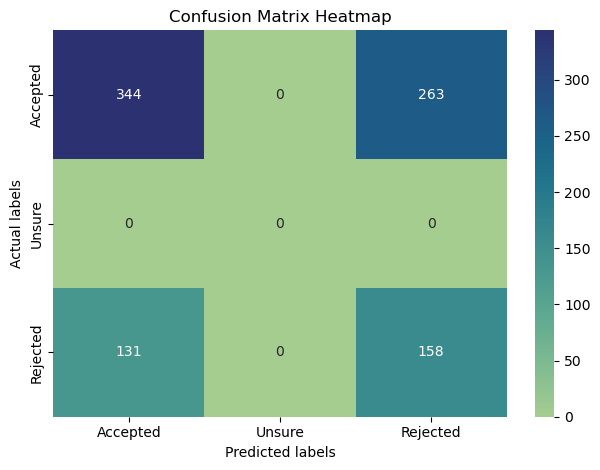

In [21]:
progress_bar = tqdm(
    total=comments.df.height,
    desc='Comment Moderation',
    unit="comments",
    smoothing=0.1,
)

moderationResults1 = DataModel(DATASET, 'moderation-results-1', DATA_PATH, schema=results_schema)

args = {
    'instructions': instructions_two_step,
    'two_step_strategy': True,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp'),
    'results': moderationResults1,
    'reject_reasons': reject_reasons,
    'context_reset': True,
    'progress_bar': progress_bar,
}

languageModel + guidance_moderation(**args)

moderationResults1.save()
progress_bar.close()

true_labels = comments.df.sort('commentId').get_column('moderated').to_numpy()
pred_labels = moderationResults1.df.sort(
    'commentId').get_column('languageModelModerated').to_numpy()

plot_confusion_matrix(true_labels, pred_labels)

### Test 2: Examples provided; second thought not enabled

In [17]:
moderationResults = DataModel(DATASET, schema=results_schema)

examples_accepted = [
    "This problem requires some serious thought and reform from our elected leaders.",
    "We need better traffic management.",
    "Every individual should have a voice and be able to make a difference.",
]

examples_rejected = [
    (
        "lol why am i even here",
        "SPAM",
        "Incoherent statement that does not contribute to the discussion in any way."
    ),
    (
        "I agree with the previous comment",
        "SPAM",
        "Does not contribute to the discussion. Polis does not support responding to other comments."
    ),
    (
        "We need better policy for public welfare and economic development. Also, we should consider the impact on the environment.",
        "COMPLEX",
        "Introduces multiple unrelated problems. It is difficult to determine where another person would agree or disagree."
    ),
]

args = {
    'instructions': instructions_two_step,
    'two_step_strategy': True,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'examples_accepted': examples_accepted,
    'examples_rejected': examples_rejected,
    'reject_reasons': reject_reasons,
    'explain': True,
}

languageModel + guidance_moderation(**args)

### Test 3: Examples not provided; second thought enabled

In [18]:
moderationResults = DataModel(DATASET, schema=results_schema)

args = {
    'instructions': instructions_two_step,
    'two_step_strategy': True,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'reject_reasons': reject_reasons,
    'thought': True,
    'explain': True,
}

languageModel + guidance_moderation(**args)

### Test 4: Examples provided and second thought enabled

In [19]:
moderationResults = DataModel(DATASET, schema=results_schema)

args = {
    'instructions': instructions_two_step,
    'two_step_strategy': True,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'examples_accepted': examples_accepted,
    'examples_rejected': examples_rejected,
    'reject_reasons': reject_reasons,
    'thought': True,
    'explain': True,
}

languageModel + guidance_moderation(**args)

### Run 4: Evaluate all comments using second-thought reasoning

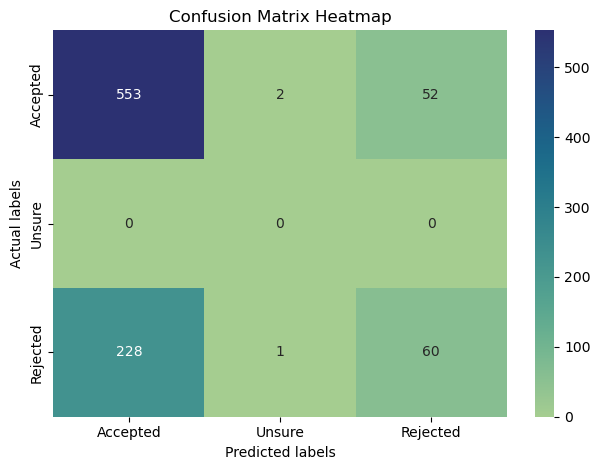

In [29]:
progress_bar = tqdm(
    total=comments.df.height,
    desc='Comment Moderation',
    unit="comments",
    smoothing=0.1,
)

moderationResults4 = DataModel(DATASET, 'moderation-results-4', DATA_PATH, schema=results_schema)

args = {
    'instructions': instructions_two_step,
    'two_step_strategy': True,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp'),
    'results': moderationResults4,
    'examples_accepted': examples_accepted,
    'examples_rejected': examples_rejected,
    'reject_reasons': reject_reasons,
    'thought': True,
    'context_reset': True,
    'progress_bar': progress_bar,
}

languageModel + guidance_moderation(**args)

moderationResults4.save()
progress_bar.close()

true_labels = comments.df.sort('commentId').get_column('moderated').to_numpy()
pred_labels = moderationResults4.df.sort(
    'commentId').get_column('languageModelModerated').to_numpy()

plot_confusion_matrix(true_labels, pred_labels)

### Discussion

Initially, the model somewhat follows instructions. Providing examples did not appear to improve the decisions. Enabling thought statement allows the model to reflect on the classification and reconsider the decision. This tends to improve reasoning abilities since the model states clearly what it intends to do before it makes a decision. However, in the following examples, it still appears to make incoherent decisions.

```
> COMMENT 12: Medical marijuana should be legal.

> REJECT
> THOUGHT: This comment is not constructive and does not contribute to the discussion. I should classify it as SPAM, but I will classify it as REJECT with the reason COMPLEX.
> CLASSIFICATION: COMPLEX
> Am I certain about this comment being COMPLEX? YES
> EXPLANATION: This comment is a statement of fact that does not contribute to the discussion.
```

In the example above, the model states its intention to classify the comment as SPAM but select COMPLEX instead. The explanation is logically sound but does not match the classification.

To address these issues, we simplify our instructions. Instead of ACCEPT/REJECT followed by a reject reason, we ask the model for a multi-label classification in single step that includes ACCEPTED, UNSURE, and several rejection categories. Since these categories are mutually exclusive, we do not need a separate step to determine the reason for rejection.


## One-step Moderation

Categorize as ACCEPTED, UNSURE, SPAM, or COMPLEX

In [19]:
classify_options = ['ACCEPT', 'UNSURE', 'SPAM', 'COMPLEX']

instructions_one_step = f"""\
You will be presented with comments posted on Polis discussion platform.
Classify each comment objectively based on whether it meets the criteria.
The comments do not have to provide a solution, but should mention a problem.
Comments should not be disrespectful or distasteful.

Discussion Title: {summary.get('topic')}
Discussion Question: {summary.get('conversation-description')}

---
Guidelines:
- ACCEPT: Comment mentions a problem, makes a suggestion, or recommends a solution.
- UNSURE: Unsure whether the comment should be accepted for discussion, especially if the comment appears harmful, unconstructive, or unhelpful.
- SPAM: Clearly incoherent or lacks seriousness.
- COMPLEX: Introduces distinct unconnected ideas using complex sentences that should be separated into multiple comments.

---
Output format:

THOUGHT: Consider the reasoning behind the classification.
CLASSIFICATION: {", ".join(classify_options)}.
REASON: If comment was not accepted, explain.
"""

print(instructions_one_step)

You will be presented with comments posted on Polis discussion platform.
Classify each comment objectively based on whether it meets the criteria.
The comments do not have to provide a solution, but should mention a problem.
Comments should not be disrespectful or distasteful.

Discussion Title: Improving Bowling Green / Warren County
Discussion Question: What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?

---
Guidelines:
- ACCEPT: Comment mentions a problem, makes a suggestion, or recommends a solution.
- UNSURE: Unsure whether the comment should be accepted for discussion, especially if the comment appears harmful, unconstructive, or unhelpful.
- SPAM: Clearly incoherent or lacks seriousness.
- COMPLEX: Introduces distinct unconnected ideas using complex sentences that should be separated into multiple comments.

---
Output format:

THOUGHT: Consider the reasoning behind the classification.
CLASSIFICATION:

### Test 5: Classify without thoughts

In [32]:
moderationResults = DataModel(DATASET, schema=results_schema)

args = {
    'instructions': instructions_one_step,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'thought': False,
    'explain': True,
}

languageModel + guidance_moderation(**args)

### Run 5: Simple moderation with no thought statements

In this run, we measure the effectiveness of our prompt without any chain-of-thought style reasoning as shown above in test 5. Context reset is enabled. This causes each comment to be removed from the context before the next one is processed, which limits the amount of context memory required and prevents us from going over the language model's context limit. However, this also means that the model cannot use the context of previous comments to inform its decisions, limiting its ability to identify duplicate comments.

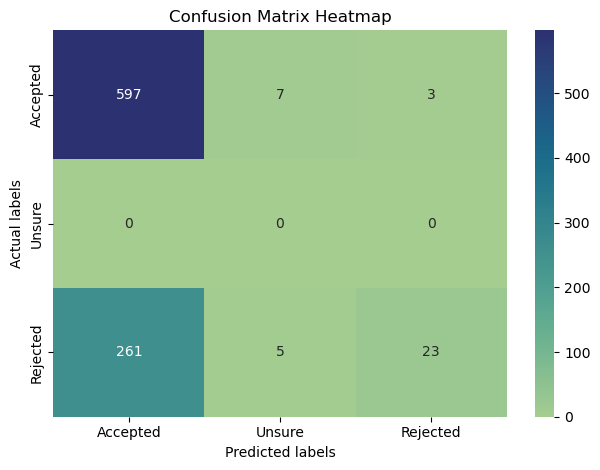

In [21]:
progress_bar = tqdm(
    total=comments.df.height,
    desc='Comment Moderation',
    unit="comments",
    smoothing=0.1,
)

moderationResults5 = DataModel(DATASET, 'moderation-results-5', DATA_PATH, schema=results_schema)


args = {
    'instructions': instructions_one_step,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp'),
    'results': moderationResults5,
    'thought': False,
    'decompose_comments': False,
    'context_reset': True,
    'progress_bar': progress_bar
}

languageModel + guidance_moderation(**args)

moderationResults5.save()
progress_bar.close()

true_labels = comments.df.sort('commentId').get_column('moderated').to_numpy()
pred_labels = moderationResults5.df.sort(
    'commentId').get_column('languageModelModerated').to_numpy()

plot_confusion_matrix(true_labels, pred_labels)

### Test 6: Classify with thoughts

In [33]:
moderationResults = DataModel(DATASET, schema=results_schema)

args = {
    'instructions': instructions_one_step,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'thought': True,
    'explain': True,
}

languageModel + guidance_moderation(**args)

### Run 6: Thought statement enabled

Here, we enable the thought statement to match the parameters of test 6.

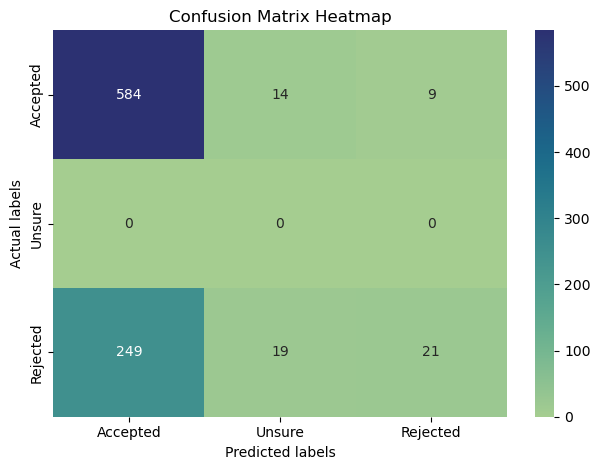

In [16]:
progress_bar = tqdm(
    total=comments.df.height,
    desc='Comment Moderation',
    unit="comments",
    smoothing=0.1,
)

moderationResults6 = DataModel(DATASET, 'moderation-results-6', DATA_PATH, schema=results_schema)


args = {
    'instructions': instructions_one_step,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp'),
    'results': moderationResults6,
    'thought': True,
    'decompose_comments': False,
    'context_reset': True,
    'progress_bar': progress_bar
}

languageModel + guidance_moderation(**args)

moderationResults6.save()
progress_bar.close()

true_labels = comments.df.sort('commentId').get_column('moderated').to_numpy()
pred_labels = moderationResults6.df.sort(
    'commentId').get_column('languageModelModerated').to_numpy()

plot_confusion_matrix(true_labels, pred_labels)

### Discussion

The above test produce more coherent results. Expressing thoughts before initial classification is more computationally expensive. However, it does improve results significantly. For example,

```
> COMMENT 1: University management bears more responsibility than federal and state education funding cuts for tuition rising so much over the years.

> THOUGHT: The comment mentions a problem and points a finger at the responsible party.
> CLASSIFICATION: ACCEPT
```

The above comment was accepted with strong reasoning. The same comment was often rejected in previous tests based on lack of accuracy or evidence, which are not valid moderation criteria. The comment meets Polis guidelines for being presented to the community for voting.

```
> COMMENT 14: I regularly discuss politics with people I disagree with.

> THOUGHT: The comment does not mention a problem or suggest a solution.
> CLASSIFICATION: UNSURE
> REASON: The comment appears to be a general statement that does not contribute to the discussion.
```

The above comment does not present any useful information, and is a candidate for additional screening. Instead of outright rejecting it, the model indicated unsurity, which allows us to flag the comment and escalate it for huamn review.

## Decompose Comments

Decomposing each comment into its requisite components might further help improve the analysis and evaluation abilities of the model. While we do not care about the accuracy or agreeability of the posted comments, we do expect either a problem or a potential solution. Also, we want the comment to present a single idea.

In the following prompt, we ask the model to idenfity the problem the comments address and their proposed solution. If neither is present, the comment is considered spam.

In [11]:
classify_options = ['ACCEPT', 'UNSURE', 'REJECT']

instructions_decompose = f"""\
Discussion Title: {summary.topic}
Discussion Question: {summary.get('conversation-description')}

---
Classify each comment objectively based on the following guidelines.

Mark the comment as:
- REJECT: frivolous, irrelevant, unrelated to the discussion.
- REJECT: does not contribute to the discussion in a meaningful way.
- REJECT: incoherent or lacks seriousness.
- REJECT: provides neither a problem nor a solution.
- REJECT: the language is informal, colloquial, disrespectful or distasteful.
- REJECT: cannot be addressed within the scope of original question.
- REJECT: introduces multiple ideas, even if they are related to the discussion.
- REJECT: Introduces distinct unconnected ideas using complex sentences that should be separated into multiple comments.
- ACCEPT: mentions a real problem related to the discussion.
- ACCEPT: recommends a realistic and actionable solution related to the discussion.
- ACCEPT: makes a sincere suggestion related to the discussion.
- UNSURE: may be accepted if it appears somewhat related to the discussion.

---
Output format:
PROBLEM: The specific problem mentioned in the comment. If only an action is suggested and no problem is explicitly mentioned, state None.
ACTION: What suggestion or change is proposed. If only a problem is mentioned and no action is suggested, state None.
HOW MANY IDEAS: Number of distinct ideas introduced in the comment.
THOUGHT: Deliberate about how the comment should be classified.
CLASSIFICATION: One of the following based on given guidelines: {", ".join(classify_options)}.
EXPLANATION: Provide an explanation for the classification.
"""

print(instructions_decompose)

Discussion Title: Improving Bowling Green / Warren County
Discussion Question: What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?

---
Classify each comment objectively based on the following guidelines:
Mark the comment as:
- ACCEPT: mentions a real problem related to the discussion.
- ACCEPT: makes a sincere suggestion or recommends a realistic and actionable solution.
- SPAM: Clearly incoherent or lacks seriousness.
- SPAM: provides neither a problem nor a solution.
- SPAM: the problem is frivolous, irrelevant, unrelated to the discussion question, or lacks seriousness.
- SPAM: the language is informal, colloquial, disrespectful or distasteful.
- SPAM: cannot be addressed within the scope of original question.
- COMPLEX: introduces multiple ideas, even if they are related to the discussion.
- COMPLEX: Introduces distinct unconnected ideas using complex sentences that should be separated into multiple comm

### Test 7: Ask Language Model to Decompose Comments

In [17]:
moderationResults = DataModel(DATASET, schema=results_schema)

args = {
    'instructions': instructions_decompose,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'thought': True,
    'decompose_comments': True,
    'explain': True,
}

languageModel + guidance_moderation(**args)

The above results might be improved through context reset, which bounds the context memory and allows the model to focus on the current comment. We will test this hypothesis in the following test.

### Run 7: Decompose Comments

In this run, we decompose each comment into its requisite components to improve the analysis and evaluation abilities of the model. This run matches the parameters of test 7.

moderation-results-4:   0%|          | 0/896 [00:00<?, ?comments/s]

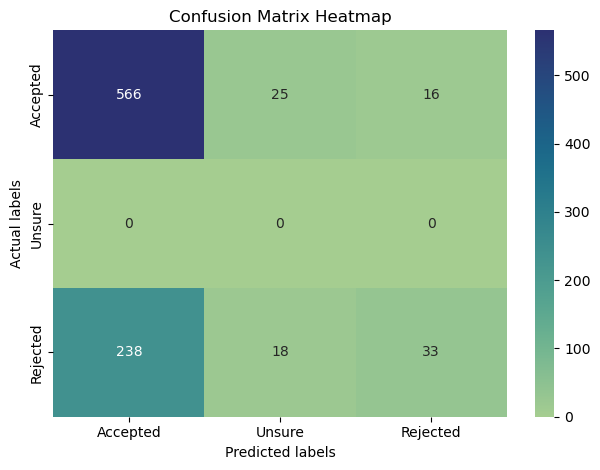

In [18]:
progress_bar = tqdm(
    total=comments.df.height,
    desc='Comment Moderation',
    unit="comments",
    smoothing=0.1,
)

moderationResults7 = DataModel(DATASET, 'moderation-results-7', DATA_PATH, schema=results_schema)

args = {
    'instructions': instructions_decompose,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp'),
    'results': moderationResults7,
    'thought': True,
    'decompose_comments': True,
    'context_reset': True,
    'progress_bar': progress_bar
}

languageModel + guidance_moderation(**args)

moderationResults7.save()
progress_bar.close()

true_labels = comments.df.sort('commentId').get_column('moderated').to_numpy()
pred_labels = moderationResults7.df.sort(
    'commentId').get_column('languageModelModerated').to_numpy()

plot_confusion_matrix(true_labels, pred_labels)

The above run took about 6 seconds per comment on H100 GPU, which is about 90 minutes for the entire dataset of ~900 comments. This is computationally expensive but appears to yield significantly better results.

### Test 8: Further refining the prompt

In [20]:
classify_options = ['ACCEPT', 'UNSURE', 'SPAM',
                    'IRRELEVANT', 'UNPROFESSIONAL', 'SCOPE', 'COMPLEX']

instructions_decompose_2 = f"""\
Discussion Title: {summary.topic}
Discussion Question: {summary.get('conversation-description')}

---
Classify each comment objectively based on the following guidelines:
- IRRELEVANT: frivolous, irrelevant, unrelated to the discussion.
- IRRELEVANT: does not contribute to the discussion in a meaningful way.
- INCOHERENT: incoherent or lacks seriousness.
- SPAM: provides neither a problem nor a solution.
- UNPROFESSIONAL: the language is informal, colloquial, disrespectful or distasteful.
- SCOPE: cannot be addressed within the scope of original question.
- COMPLEX: introduces multiple ideas, even if they are related to the discussion.
- COMPLEX: Introduces distinct unconnected ideas using complex sentences that should be separated into multiple comments.
- ACCEPT: mentions a real problem related to the discussion.
- ACCEPT: recommends a realistic and actionable solution related to the discussion.
- ACCEPT: makes a sincere suggestion related to the discussion.
- UNSURE: may be accepted if it appears somewhat related to the discussion.

---
Output format:
PROBLEM: The specific problem mentioned in the comment. If only an action is suggested and no problem is explicitly mentioned, state None.
ACTION: What suggestion or change is proposed. If only a problem is mentioned and no action is suggested, state None.
HOW MANY IDEAS: Number of distinct ideas introduced in the comment.
THOUGHT: Deliberate about how the comment should be classified.
CLASSIFICATION: One of the following based on given guidelines: {", ".join(classify_options)}.
EXPLANATION: Provide an explanation for the classification.
"""

print(instructions_decompose_2)

Discussion Title: Improving Bowling Green / Warren County
Discussion Question: What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?

---
Classify each comment objectively based on the following guidelines:
Mark the comment as:
- IRRELEVANT: frivolous, irrelevant, unrelated to the discussion.
- IRRELEVANT: does not contribute to the discussion in a meaningful way.
- INCOHERENT: incoherent or lacks seriousness.
- SPAM: provides neither a problem nor a solution.
- UNPROFESSIONAL: the language is informal, colloquial, disrespectful or distasteful.
- SCOPE: cannot be addressed within the scope of original question.
- COMPLEX: introduces multiple ideas, even if they are related to the discussion.
- COMPLEX: Introduces distinct unconnected ideas using complex sentences that should be separated into multiple comments.
- ACCEPT: mentions a real problem related to the discussion.
- ACCEPT: recommends a realistic and act

In [21]:
moderationResults = DataModel(DATASET, schema=results_schema)

args = {
    'instructions': instructions_decompose_2,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp').head(20),
    'results': moderationResults,
    'thought': True,
    'decompose_comments': True,
    'explain': True,
}

languageModel + guidance_moderation(**args)

### Run 8: Refine Decomposition Prompt

Comment Moderation:   0%|          | 0/896 [00:00<?, ?comments/s]

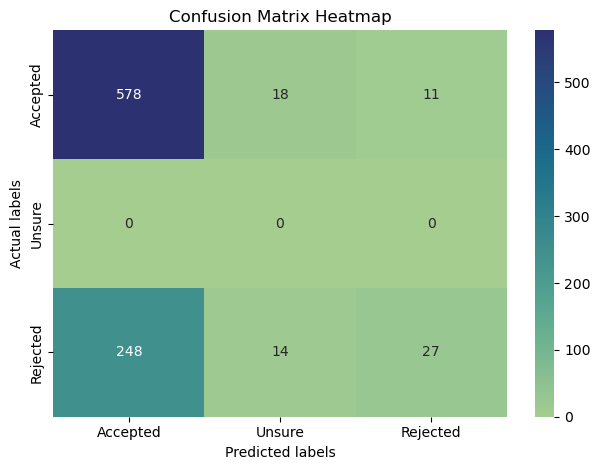

In [22]:
progress_bar = tqdm(
    total=comments.df.height,
    desc="Comment Moderation",
    unit="comments",
    smoothing=0.1,
)

moderationResults8 = DataModel(DATASET, 'moderation-results-8', DATA_PATH, schema=results_schema)

args = {
    'instructions': instructions_decompose_2,
    'classify_options': classify_options,
    'comments_df': comments.df.sort('timestamp'),
    'results': moderationResults8,
    'thought': True,
    'decompose_comments': True,
    'context_reset': True,
    'progress_bar': progress_bar
}

languageModel + guidance_moderation(**args)

moderationResults8.save()
progress_bar.close()

true_labels = comments.df.sort('commentId').get_column('moderated').to_numpy()
pred_labels = moderationResults8.df.sort(
    'commentId').get_column('languageModelModerated').to_numpy()

plot_confusion_matrix(true_labels, pred_labels)

## Further Analysis

#### Notes: Prompt Refinements

REJECT:
- does not provide a solution or mention a problem
- informal and colloquial
- relevant to posted question
- The comment introduces multiple ideas, but they are all related to improving the area.
- if no problem identified, say so
- if no solution identified, say so
- Cannot be addressed within the scope of original question.


> Comment: Bowling Green needs a homeless shelter. (Moderated: -1)
> - PROBLEM: Bowling Green lacks a homeless shelter.
> - ACTION: Establish a homeless shelter in Bowling Green.
> - THOUGHT: The comment identifies a problem and proposes a solution.

No problem identified - only a solution

> Comment: The driving conditions on the 31-W bypass are very poor and need to be changed. (Moderated: -1)
> - PROBLEM: The driving conditions on the 31-W bypass are very poor.
> - ACTION: Change the driving conditions on the 31-W bypass.
> - THOUGHT: The comment mentions a problem and suggests a solution, so it should be accepted.

No solution identified - only a problem

Comment: Bowling Green should become a Metro. (Moderated: -1)
- PROBLEM: Bowling Green does not have a metro system.
- ACTION: Implement a metro system in Bowling Green.

> Comment: Know who all your neighbors are (Moderated: -1)
> - PROBLEM: Lack of familiarity with neighbors.
> - ACTION: Encourage getting to know neighbors.
> - IDEAS: 1
> - THOUGHT: The comment mentions a problem and suggests a solution.

Cannot be addressed within the scope of original question.

### Future Work

We should consider the effect of `temperature` on spam classification. For the above experiment, we kept `temperature = 0` to limit randomness and allow reproducibility of results. However, a higher temperature might allow the model to explore more options and improve its reasoning abilities, especially when employing the chain-of-thought reasoning approach.

<!-- Context Reset: In the first iteration, we write the instructions to the context and then ask the model to moderate one comment at a time. After each decision, the comment is removed and the next one is placed in the context. This bounds the context memory, speeds up the computation, and improves the model's ability to follow instructions. -->